Our project aims to analyze the socio-economic and demographic determinants of child stunting in India using the National Family Health Survey (NFHS-5) dataset.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import  RandomForestClassifier


In [44]:
# Correct the file path to point to the actual location of the file

data = pd.read_excel('NFHS_5_Factsheets_Data.xls')  # Ensure the file is in the same directory as the notebook
data.head()

,States/UTs,Area,Number of Households surveyed,Number of Women age 15-49 years interviewed,Number of Men age 15-54 years interviewed,Female population age 6 years and above who ever attended school (%),Population below age 15 years (%),"Sex ratio of the total population (females per 1,000 males)","Sex ratio at birth for children born in the last five years (females per 1,000 males)",Children under age 5 years whose birth was registered with the civil authority (%),...,Women (age 15-49 years) having a bank or savings account that they themselves use (%),Women (age 15-49 years) having a mobile phone that they themselves use (%),Women age 15-24 years who use hygienic methods of protection during their menstrual period26 (%),Ever-married women age 18-49 years who have ever experienced spousal violence27 (%),Ever-married women age 18-49 years who have experienced physical violence during any pregnancy (%),Young women age 18-29 years who experienced sexual violence by age 18 (%),Women age 15 years and above who use any kind of tobacco (%),Men age 15 years and above who use any kind of tobacco (%),Women age 15 years and above who consume alcohol (%),Men age 15 years and above who consume alcohol (%)
0,India,Urban,160138,179535,26420,82.51,23.14,985.28,924.35,93.3,...,80.93,69.36,89.37,24.19,2.51,1.1,5.44,28.82,0.58,16.53
1,India,Rural,476561,544580,75419,66.77,28.10,1037.29,930.94,87.53,...,77.43,46.61,72.32,31.63,3.41,1.64,10.49,42.69,1.61,19.92
2,India,Total,636699,724115,101839,71.76,26.52,1020.45,929.16,89.08,...,78.56,53.95,77.33,29.31,3.13,1.48,8.85,37.99,1.28,18.77
3,Andaman & Nicobar Islands,Urban,527,557,85,86.46,22.67,1022.74,941.04,96.86,...,88.48,80.79,98.47,23.19,-0.01,1.37,14.95,44.71,0.69,33.83
4,Andaman & Nicobar Islands,Rural,2097,1840,282,81.75,19.69,929.23,891.11,97.84,...,89.75,80.86,99.12,13.22,0.5,2.16,41.06,66.39,7.60,41.94


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Columns: 136 entries, States/UTs to Men age 15 years and above who consume alcohol (%)
dtypes: float64(25), int64(3), object(108)
memory usage: 118.1+ KB


In [46]:
for col in data.columns:
        print(f"'{col}'")


'States/UTs'
'Area'
'Number of Households surveyed'
'Number of Women age 15-49 years interviewed'
'Number of Men age 15-54 years interviewed'
'Female population age 6 years and above who ever attended school (%)'
'Population below age 15 years (%)'
' Sex ratio of the total population (females per 1,000 males)'
'Sex ratio at birth for children born in the last five years (females per 1,000 males)'
'Children under age 5 years whose birth was registered with the civil authority (%)'
'Deaths in the last 3 years registered with the civil authority (%)'
'Population living in households with electricity (%)'
'Population living in households with an improved drinking-water source1 (%)'
'Population living in households that use an improved sanitation facility2 (%)'
'Households using clean fuel for cooking3 (%)'
'Households using iodized salt (%)'
'Households with any usual member covered under a health insurance/financing scheme (%)'
'Children age 5 years who attended pre-primary school during 

In [47]:
columns_to_use = [
    # Target variables
    'Children under 5 years who are stunted (height-for-age)18 (%)',
    'Children under 5 years who are wasted (weight-for-height)18 (%)',
    'Children under 5 years who are underweight (weight-for-age)18 (%)',
    
    # Child-specific features
    'Children under age 6 months exclusively breastfed16 (%)',
    'Children under age 3 years breastfed within one hour of birth15 (%)',
    'Total children age 6-23 months receiving an adequate diet16, 17  (%)',
    'Prevalence of diarrhoea in the 2 weeks preceding the survey (Children under age 5 years) (%) ',
    'Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%)  ',
    
    # Maternal/Parental features
    'Women (age 15-49) who are literate4 (%)',
    'Women (age 15-49)  with 10 or more years of schooling (%)',
    'Women (age 15-49 years) whose Body Mass Index (BMI) is below normal (BMI <18.5 kg/m2)21 (%)',
    'Mothers who had at least 4 antenatal care visits  (for last birth in the 5 years before the survey) (%)',
    'Mothers who consumed iron folic acid for 100 days or more when they were pregnant (for last birth in the 5 years before the survey) (%)',
    'Women age 20-24 years married before age 18 years (%)',
    'Women (age 15-49)  who have ever used the internet (%)',
    
    # Household & socio-economic
    'Population living in households with electricity (%)',
    'Population living in households with an improved drinking-water source1 (%)',
    'Population living in households that use an improved sanitation facility2 (%)',
    'Households using clean fuel for cooking3 (%)',
    'Households using iodized salt (%)',
    'Households with any usual member covered under a health insurance/financing scheme (%)',
    
    # Health & fertility
    'Total Fertility Rate (number of children per woman)',
    'Neonatal mortality rate (per 1000 live births)',
    'Infant mortality rate (per 1000 live births)',
    'Under-five mortality rate (per 1000 live births)',
    'Current Use of Family Planning Methods (Currently Married Women Age 15-49  years) - Any method6 (%)'
]
data = data[columns_to_use] 
data.head()

,Children under 5 years who are stunted (height-for-age)18 (%),Children under 5 years who are wasted (weight-for-height)18 (%),Children under 5 years who are underweight (weight-for-age)18 (%),Children under age 6 months exclusively breastfed16 (%),Children under age 3 years breastfed within one hour of birth15 (%),"Total children age 6-23 months receiving an adequate diet16, 17 (%)",Prevalence of diarrhoea in the 2 weeks preceding the survey (Children under age 5 years) (%),Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%),Women (age 15-49) who are literate4 (%),Women (age 15-49) with 10 or more years of schooling (%),...,Population living in households with an improved drinking-water source1 (%),Population living in households that use an improved sanitation facility2 (%),Households using clean fuel for cooking3 (%),Households using iodized salt (%),Households with any usual member covered under a health insurance/financing scheme (%),Total Fertility Rate (number of children per woman),Neonatal mortality rate (per 1000 live births),Infant mortality rate (per 1000 live births),Under-five mortality rate (per 1000 live births),Current Use of Family Planning Methods (Currently Married Women Age 15-49 years) - Any method6 (%)
0,30.12,18.54,27.34,59.63,44.67,12.25,6.16,72.7,83.01,56.28,...,98.67,81.47,89.65,96.92,38.08,1.63,17.96,26.56,31.45,69.26
1,37.34,19.51,33.78,65.06,40.68,10.96,7.71,67.82,65.90,33.70,...,94.57,64.90,43.21,92.97,42.44,2.14,27.45,38.36,45.69,65.55
2,35.47,19.26,32.11,63.72,41.75,11.3,7.3,69.01,71.46,41.04,...,95.87,70.17,58.62,94.28,40.99,1.99,24.91,35.2,41.86,66.71
3,18.15,12.83,15.07,*,45.76,-27.74,6.23,-80.97,86.55,59.71,...,98.03,87.95,95.63,99.65,1.44,1.44,*,*,*,54.43
4,26.42,18.95,31.14,*,47.78,10.59,5.13,64.64,85.58,47.57,...,95.31,87.98,71.01,99.74,1.61,1.17,-2.82,-8.39,-9.46,73.38


In [48]:
# Check basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 26 columns):
 #   Column                                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                                       --------------  -----  
 0   Children under 5 years who are stunted (height-for-age)18 (%)                                                                                                111 non-null    object 
 1   Children under 5 years who are wasted (weight-for-height)18 (%)                                                                                              111 non-null    object 
 2   Children under 5 years who are underweight (weight-for-age)18 (%)                                                                                 

In [50]:
# Replace '*' with NaN
data = data.replace('*', np.nan)
data[data < 0] = np.nan

In [51]:
# Check missing values
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
missing_df.sort_values(by='Missing Percent', ascending=False)


,Missing Count,Missing Percent
Children under age 6 months exclusively breastfed16 (%),23,20.720721
Neonatal mortality rate (per 1000 live births),22,19.819820
Infant mortality rate (per 1000 live births),22,19.819820
Under-five mortality rate (per 1000 live births),21,18.918919
Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%),17,15.315315
"Total children age 6-23 months receiving an adequate diet16, 17 (%)",11,9.909910
Women (age 15-49) who have ever used the internet (%),3,2.702703
Children under age 3 years breastfed within one hour of birth15 (%),3,2.702703
Women age 20-24 years married before age 18 years (%),2,1.801802
Children under 5 years who are wasted (weight-for-height)18 (%),1,0.900901


In [52]:
data = data.apply(pd.to_numeric)

#  Replace numeric NaN values with column mean
for col in data.select_dtypes(include=np.number).columns:
    mean_value = data[col].mean()
    data[col] = data[col].fillna(mean_value)

In [53]:
# Check missing values
data = data.replace('*', np.nan)
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
missing_df.sort_values(by='Missing Percent', ascending=False)

,Missing Count,Missing Percent
Children under 5 years who are stunted (height-for-age)18 (%),0,0.0
Children under 5 years who are wasted (weight-for-height)18 (%),0,0.0
Children under 5 years who are underweight (weight-for-age)18 (%),0,0.0
Children under age 6 months exclusively breastfed16 (%),0,0.0
Children under age 3 years breastfed within one hour of birth15 (%),0,0.0
"Total children age 6-23 months receiving an adequate diet16, 17 (%)",0,0.0
Prevalence of diarrhoea in the 2 weeks preceding the survey (Children under age 5 years) (%),0,0.0
Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%),0,0.0
Women (age 15-49) who are literate4 (%),0,0.0
Women (age 15-49) with 10 or more years of schooling (%),0,0.0


In [75]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
# Get descriptive statistics (transposed for readability)
display(data.describe().T.style.background_gradient(cmap='Blues'))

,count,mean,std,min,25%,50%,75%,max
Children under 5 years who are stunted (height-for-age)18 (%),111.000000,30.577545,6.383896,15.050000,26.210000,30.577545,34.805000,48.210000
Children under 5 years who are wasted (weight-for-height)18 (%),111.000000,16.875182,4.393657,7.550000,13.175000,17.550000,19.515000,27.330000
Children under 5 years who are underweight (weight-for-age)18 (%),111.000000,25.515727,8.057675,9.040000,20.065000,25.600000,31.965000,43.520000
Children under age 6 months exclusively breastfed16 (%),111.000000,62.941250,9.209587,28.250000,59.795000,62.941250,68.970000,81.520000
Children under age 3 years breastfed within one hour of birth15 (%),111.000000,48.645278,13.292837,19.430000,39.340000,49.170000,58.225000,79.930000
"Total children age 6-23 months receiving an adequate diet16, 17 (%)",111.000000,14.670400,6.212815,5.500000,9.945000,13.600000,18.975000,39.480000
Prevalence of diarrhoea in the 2 weeks preceding the survey (Children under age 5 years) (%),111.000000,6.016727,2.652090,0.960000,4.265000,5.580000,7.165000,13.860000
Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%),111.000000,65.829362,10.863187,24.390000,62.360000,65.829362,71.350000,90.650000
Women (age 15-49) who are literate4 (%),111.000000,81.213545,10.051858,54.540000,75.160000,82.960000,87.680000,99.140000
Women (age 15-49) with 10 or more years of schooling (%),111.000000,48.343000,14.463395,17.890000,35.970000,49.060000,59.820000,79.780000


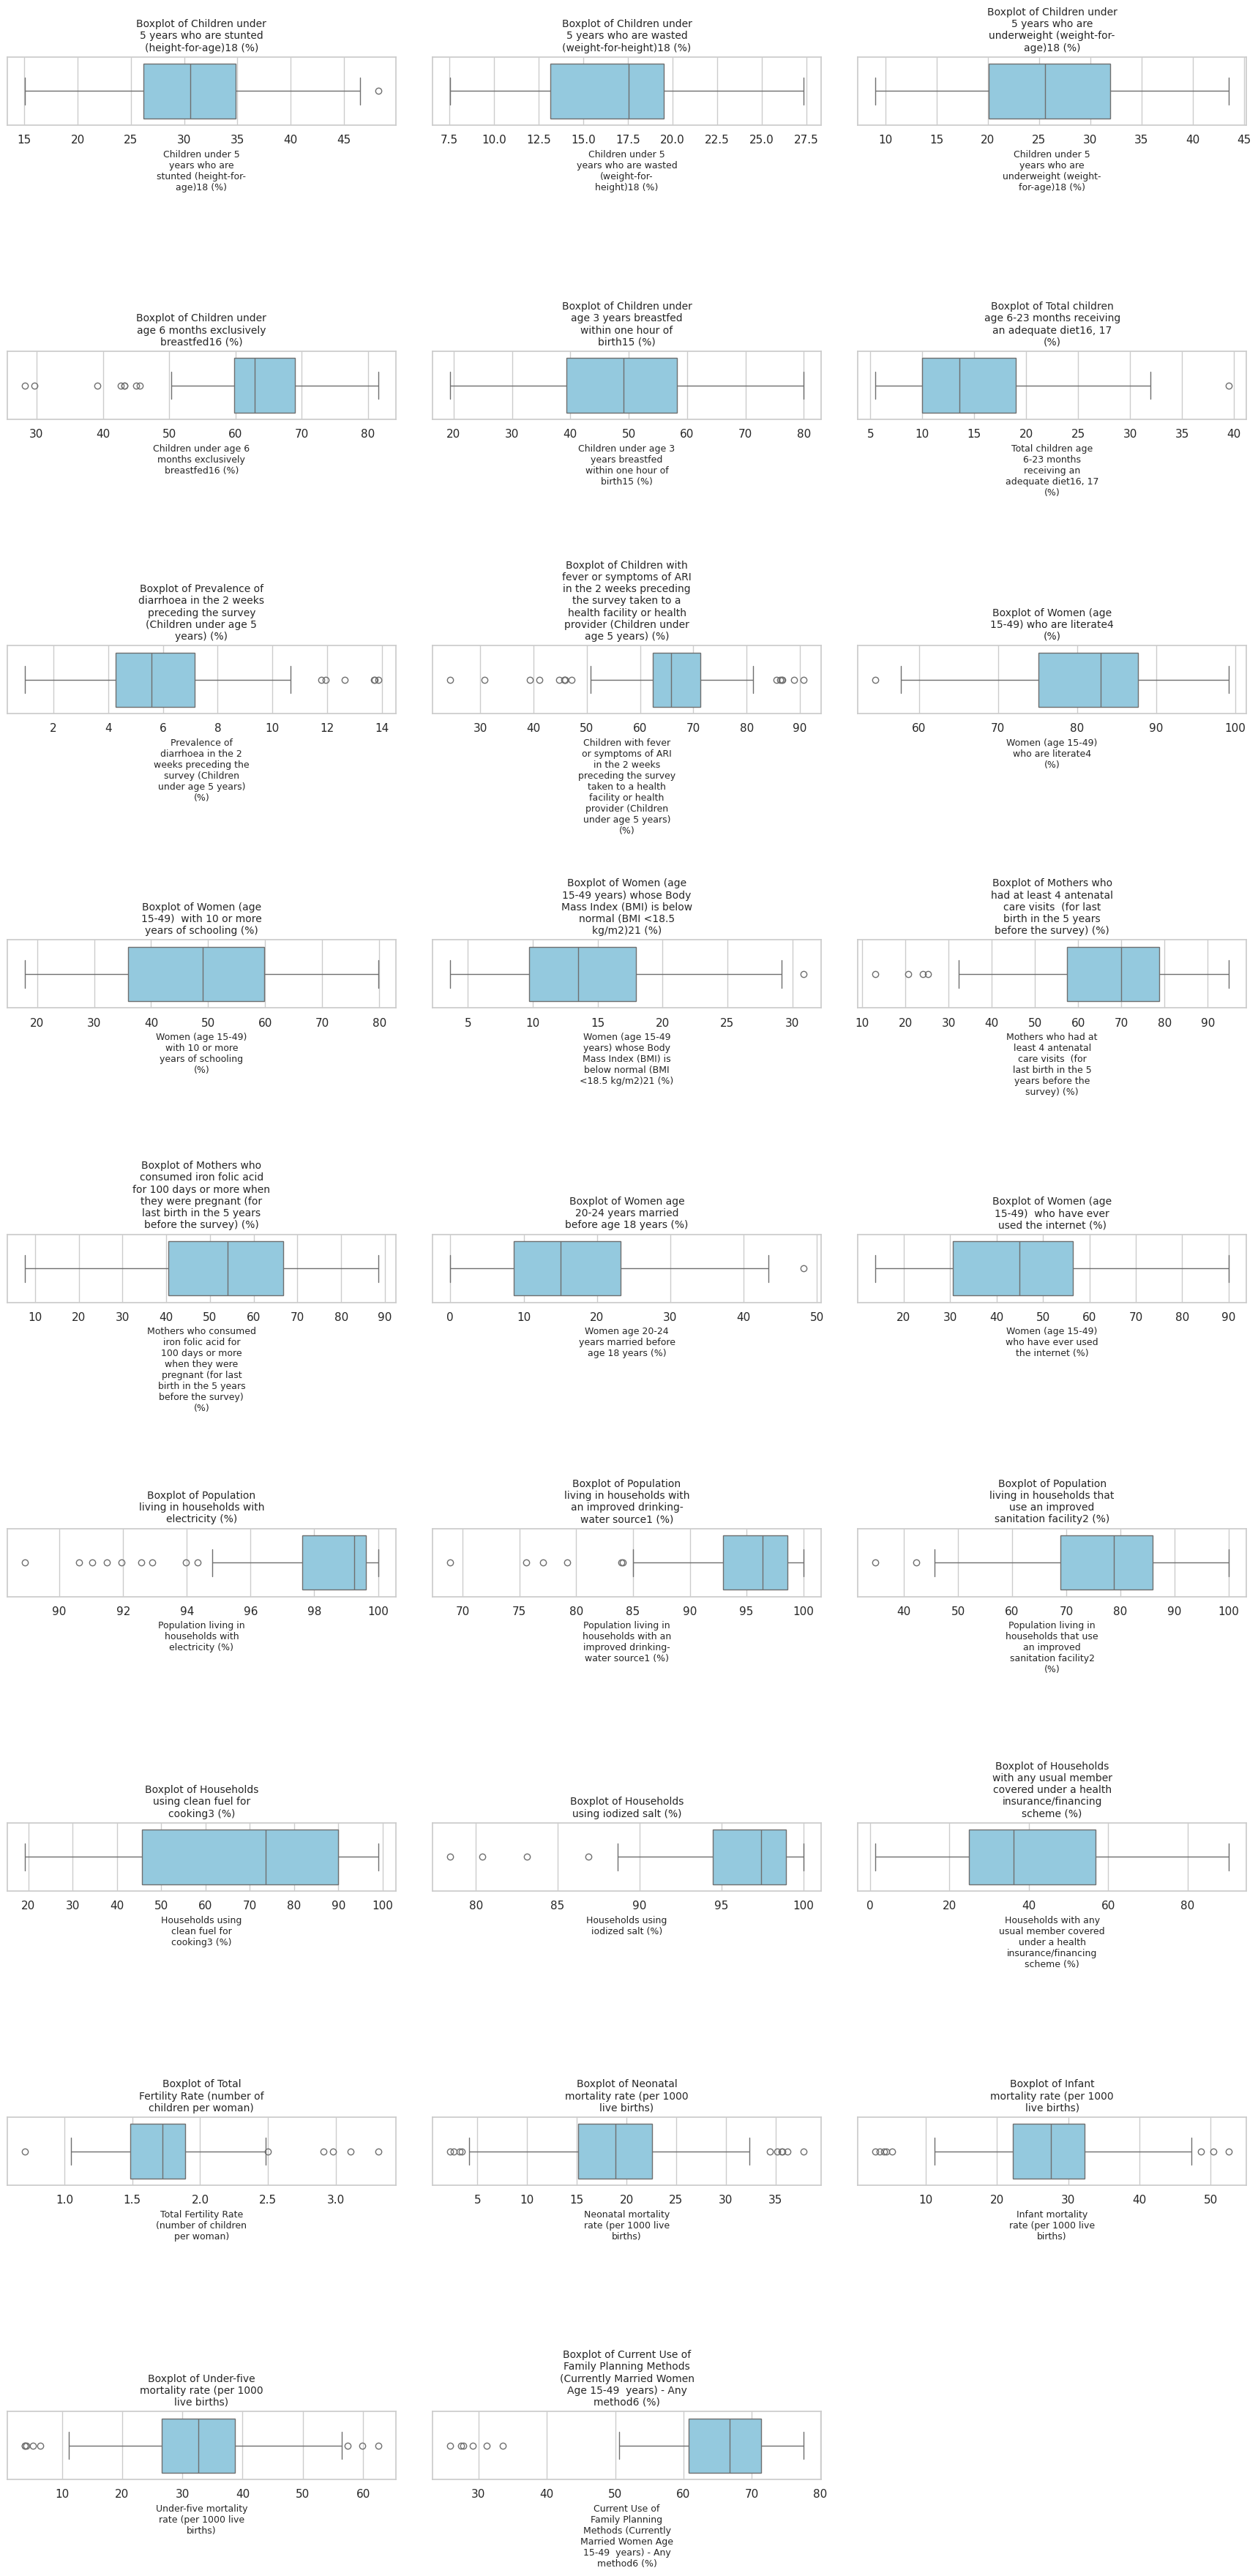

In [55]:
# Number of columns per row
numeric_cols = data.select_dtypes(include=np.number).columns
n_cols = 3
n_plots = len(numeric_cols)
n_rows = (n_plots + n_cols - 1) // n_cols  # round up number of rows
plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=data[col], color="skyblue")

    # Wrap long text for title and labels
    title = textwrap.fill(f"Boxplot of {col}", width=25)
    xlabel = textwrap.fill(col, width=20)

    plt.title(title, fontsize=10)
    plt.xlabel(xlabel, fontsize=9)

# Add spacing between plots
plt.tight_layout(pad=3.0, w_pad=2.5, h_pad=3.5)

plt.show()

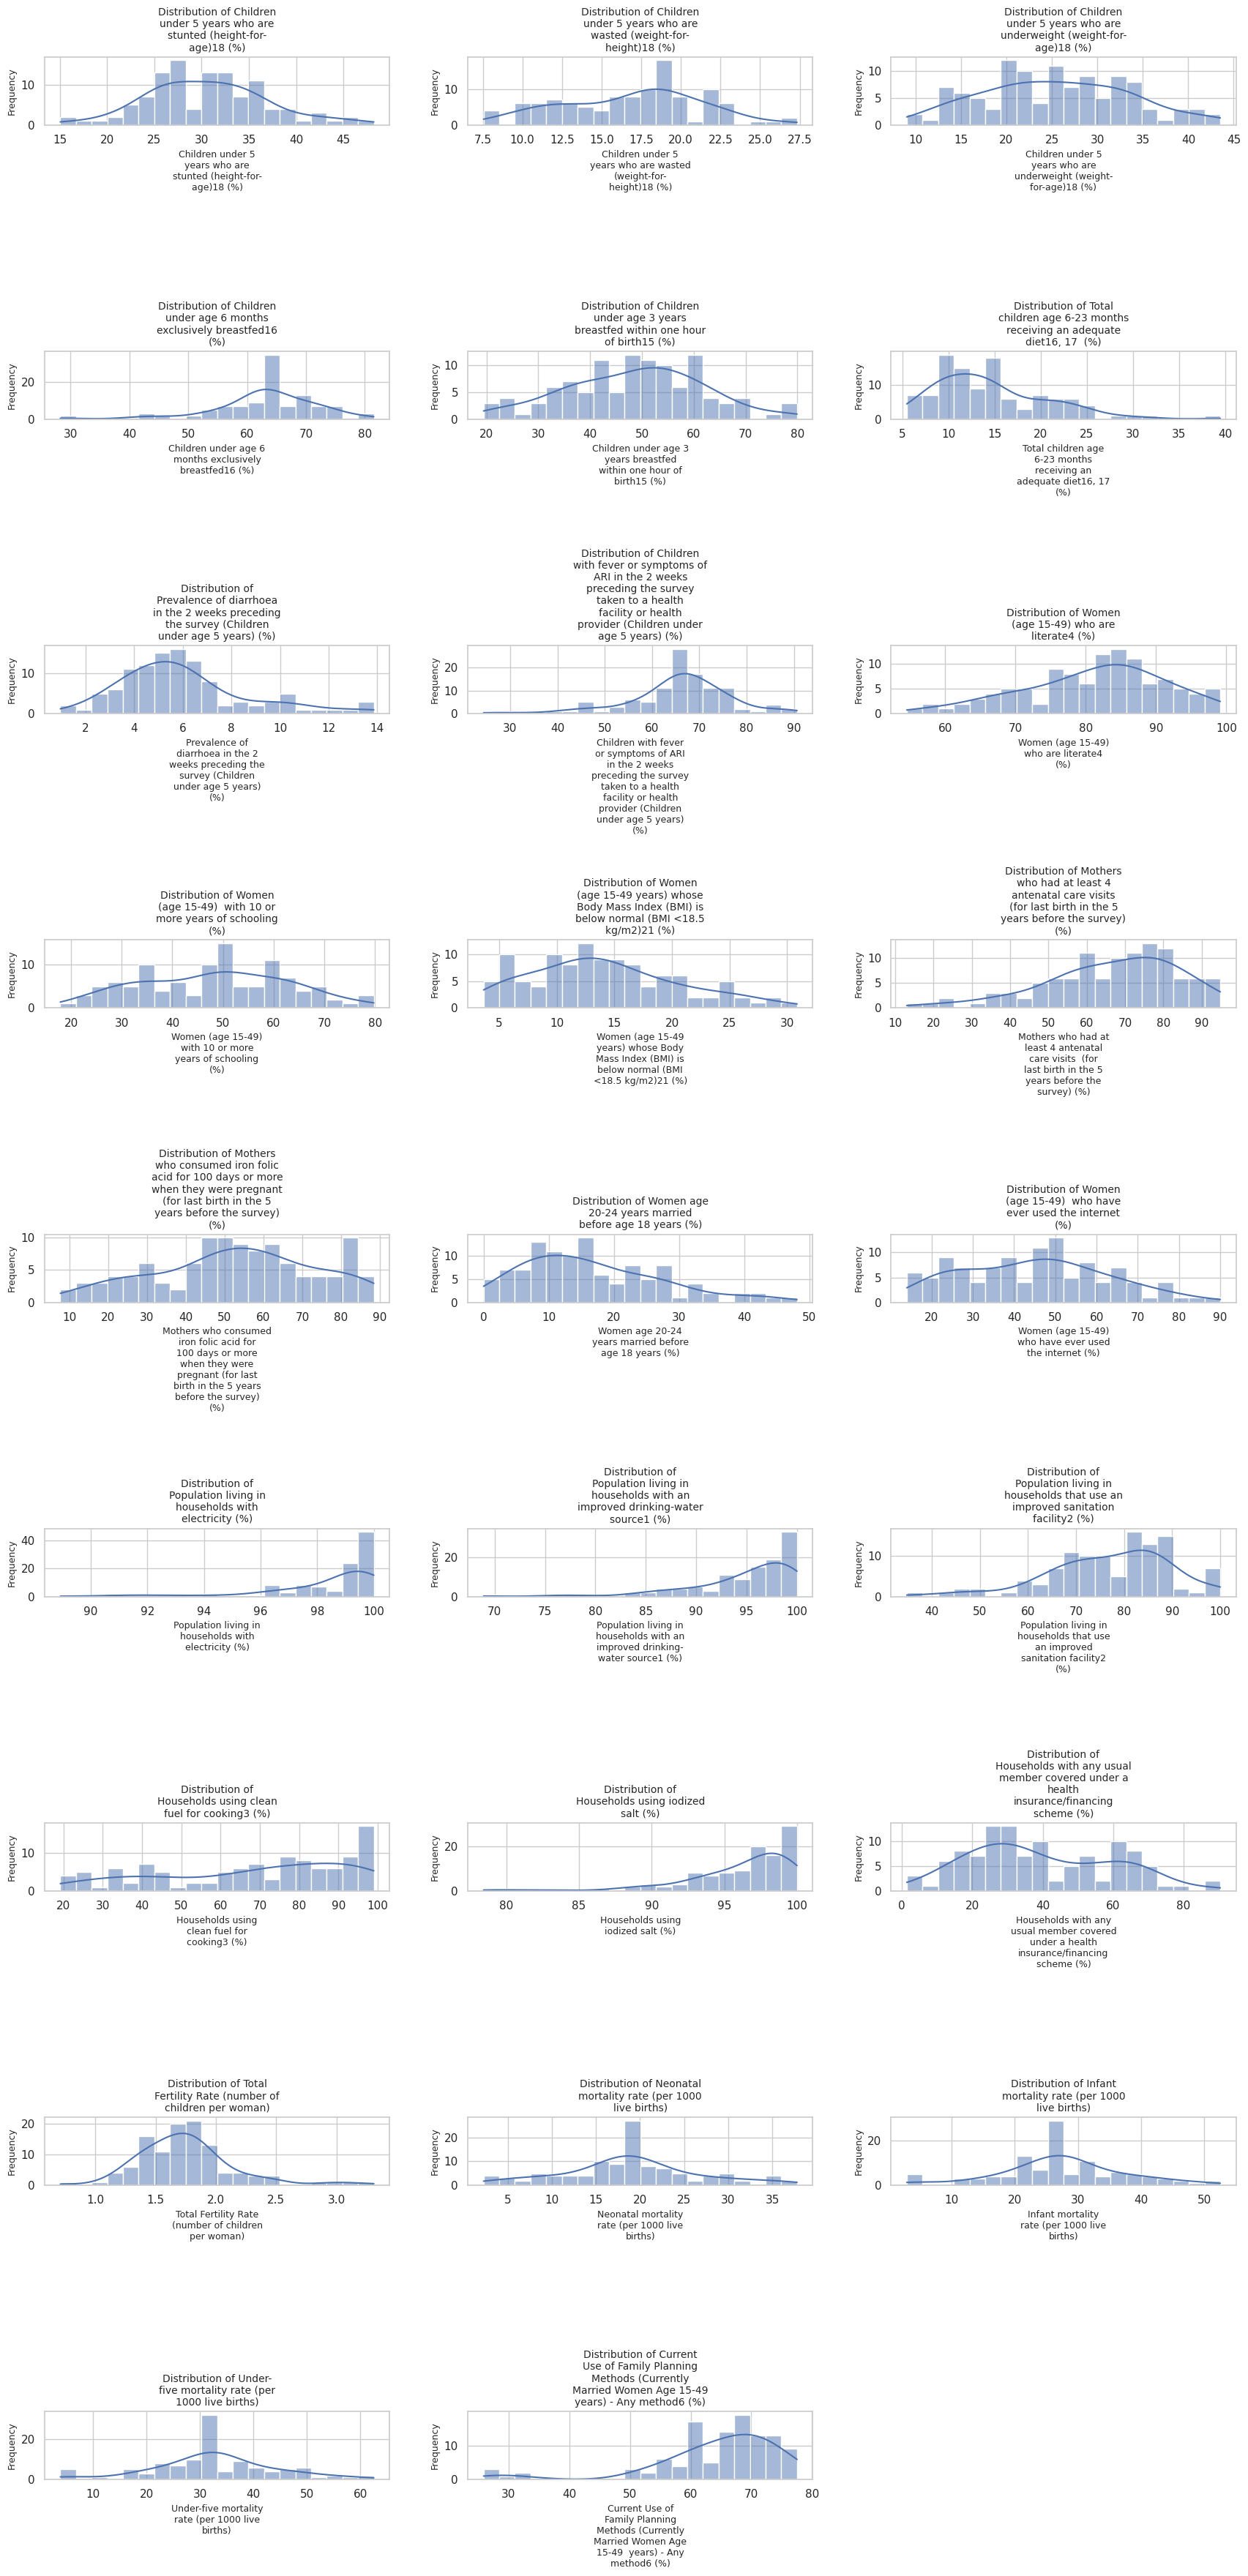

In [56]:
# Number of columns per row
numeric_cols = data.select_dtypes(include=np.number).columns
n_cols = 3
n_plots = len(numeric_cols)
n_rows = (n_plots + n_cols - 1) // n_cols  # round up number of rows

plt.figure(figsize=(n_cols * 6, n_rows * 4))  # overall figure size

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data[col].dropna(), kde=True, bins=20)

    # Wrap title and axis labels to avoid overlap
    title = textwrap.fill(f"Distribution of {col}", width=25)
    xlabel = textwrap.fill(col, width=20)
    ylabel = textwrap.fill("Frequency", width=15)

    plt.title(title, fontsize=10)
    plt.xlabel(xlabel, fontsize=9)
    plt.ylabel(ylabel, fontsize=9)

# Add space between subplots
plt.tight_layout(pad=3.0, w_pad=2.5, h_pad=3.5)

plt.show()

In [57]:
# -----------------------------
# Define targets
# -----------------------------
target_cols = [
    'Children under 5 years who are stunted (height-for-age)18 (%)',
    'Children under 5 years who are wasted (weight-for-height)18 (%)',
    'Children under 5 years who are underweight (weight-for-age)18 (%)'
]

In [58]:
X = data.drop(columns=target_cols)
y = data[target_cols].apply(pd.to_numeric, errors='coerce')

In [59]:
y_class = (y > y.median()).astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

models_class = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

results_class = []

for name, model in models_class.items():
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler(with_mean=False)),
        ('model', MultiOutputRegressor(model))
    ])
    
    pipeline.fit(X_train_c, y_train_c)
    y_pred = pipeline.predict(X_test_c)

    # Compute accuracy per target and average
    accs = [accuracy_score(y_test_c[col], y_pred[:, i]) for i, col in enumerate(target_cols)]
    avg_acc = np.mean(accs)
    results_class.append([name, avg_acc])
    
    print(f"🤖 Model: {name}")
    for i, col in enumerate(target_cols):
        print(f"Target: {col} — Accuracy: {accs[i]:.2f}")
    print(f"Average Accuracy: {avg_acc:.2f}")
    print("-" * 60)

# Classification results summary
results_class_df = pd.DataFrame(results_class, columns=["Model", "Average Accuracy"])
print("\n📊 CLASSIFICATION MODEL COMPARISON:")
print(results_class_df)    


🤖 Model: Logistic Regression
Target: Children under 5 years who are stunted (height-for-age)18 (%) — Accuracy: 0.52
Target: Children under 5 years who are wasted (weight-for-height)18 (%) — Accuracy: 0.74
Target: Children under 5 years who are underweight (weight-for-age)18 (%) — Accuracy: 0.70
Average Accuracy: 0.65
------------------------------------------------------------
🤖 Model: Decision Tree
Target: Children under 5 years who are stunted (height-for-age)18 (%) — Accuracy: 0.70
Target: Children under 5 years who are wasted (weight-for-height)18 (%) — Accuracy: 0.57
Target: Children under 5 years who are underweight (weight-for-age)18 (%) — Accuracy: 0.65
Average Accuracy: 0.64
------------------------------------------------------------
🤖 Model: Random Forest
Target: Children under 5 years who are stunted (height-for-age)18 (%) — Accuracy: 0.70
Target: Children under 5 years who are wasted (weight-for-height)18 (%) — Accuracy: 0.74
Target: Children under 5 years who are underwei

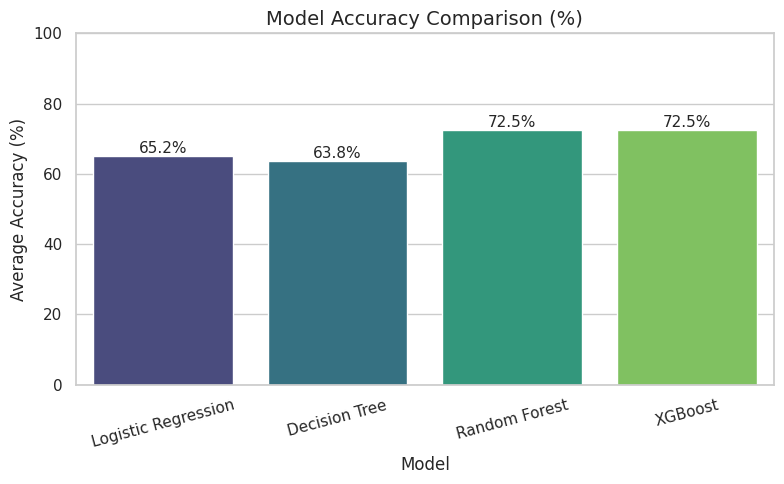

In [64]:
# Convert accuracy to percentage
results_class_df['Average Accuracy (%)'] = results_class_df['Average Accuracy'] * 100

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(8,5))
barplot = sns.barplot(
    x='Model',hue='Model',
    y='Average Accuracy (%)',
    data=results_class_df,
    palette='viridis'
)

# Add accuracy labels on top of each bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.1f}%', 
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=11)

plt.title('Model Accuracy Comparison (%)', fontsize=14)
plt.ylabel('Average Accuracy (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [65]:
def plot_actual_vs_pred_classification(models, X_train, y_train, X_test, y_test, targets):
    """
    Trains multi-output classification models and shows confusion matrices
    for each target variable.
    """
    for name, model in models.items():
        print(f"\n📊 Model: {name}")

        # Build preprocessing + model pipeline
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=False)),
            ('model', MultiOutputRegressor(model))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Plot confusion matrices for each target
        n_targets = len(targets)
        plt.figure(figsize=(5 * n_targets, 5))

        for i, target in enumerate(targets):
            plt.subplot(1, n_targets, i + 1)
            cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i].astype(int))
            disp = ConfusionMatrixDisplay(cm, display_labels=["Low", "High"])
            disp.plot(cmap="YlGnBu", ax=plt.gca(), colorbar=False)
            acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i].astype(int))
            wrapped_target = "\n".join(textwrap.wrap(target, width=35))  # wrap every 15 characters
            plt.title(f"{wrapped_target}\nAccuracy = {acc:.2f}")

        plt.suptitle(f"Actual vs Predicted (Confusion Matrices) — {name}", fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()



📊 Model: Logistic Regression


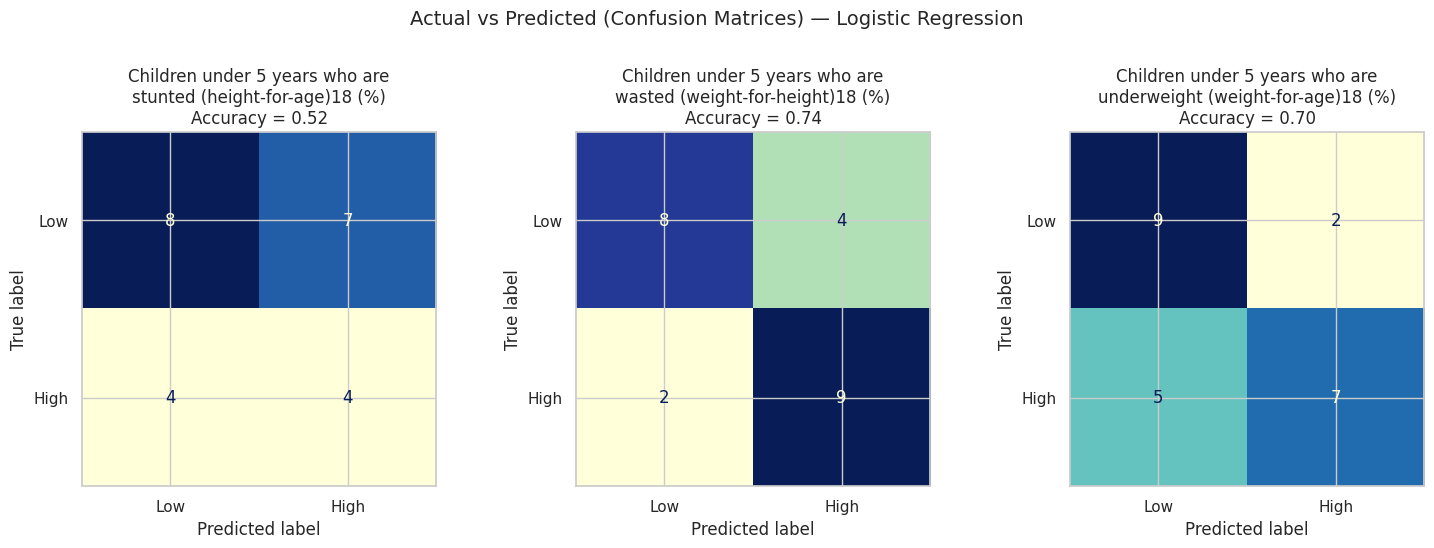


📊 Model: Decision Tree


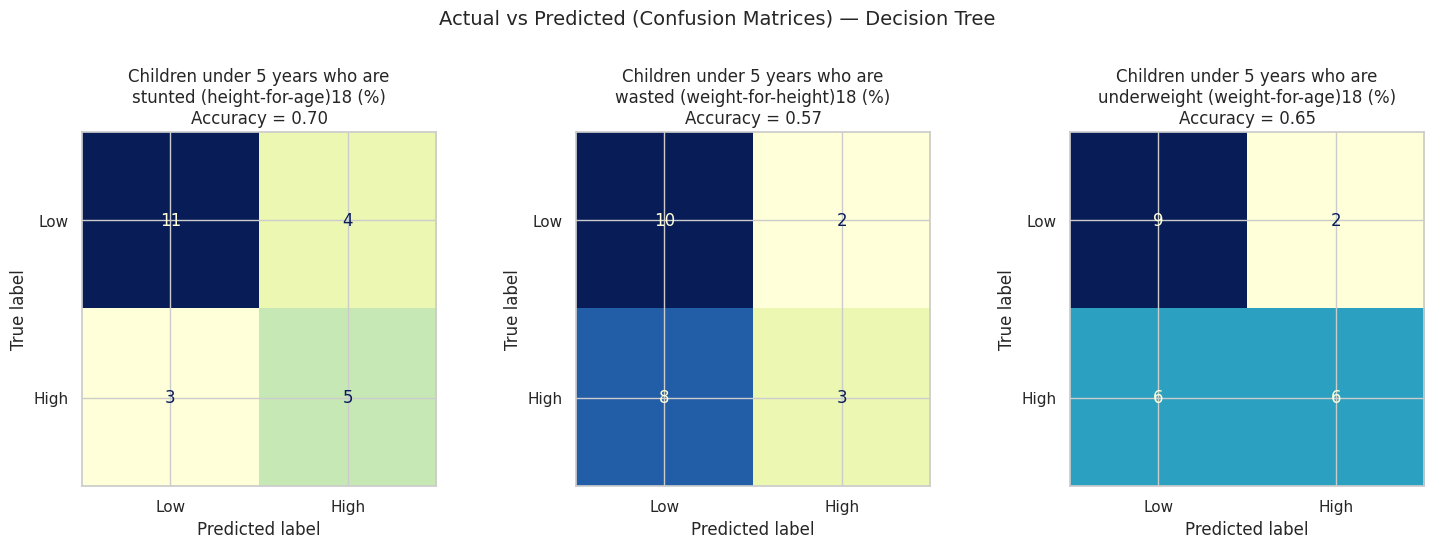


📊 Model: Random Forest


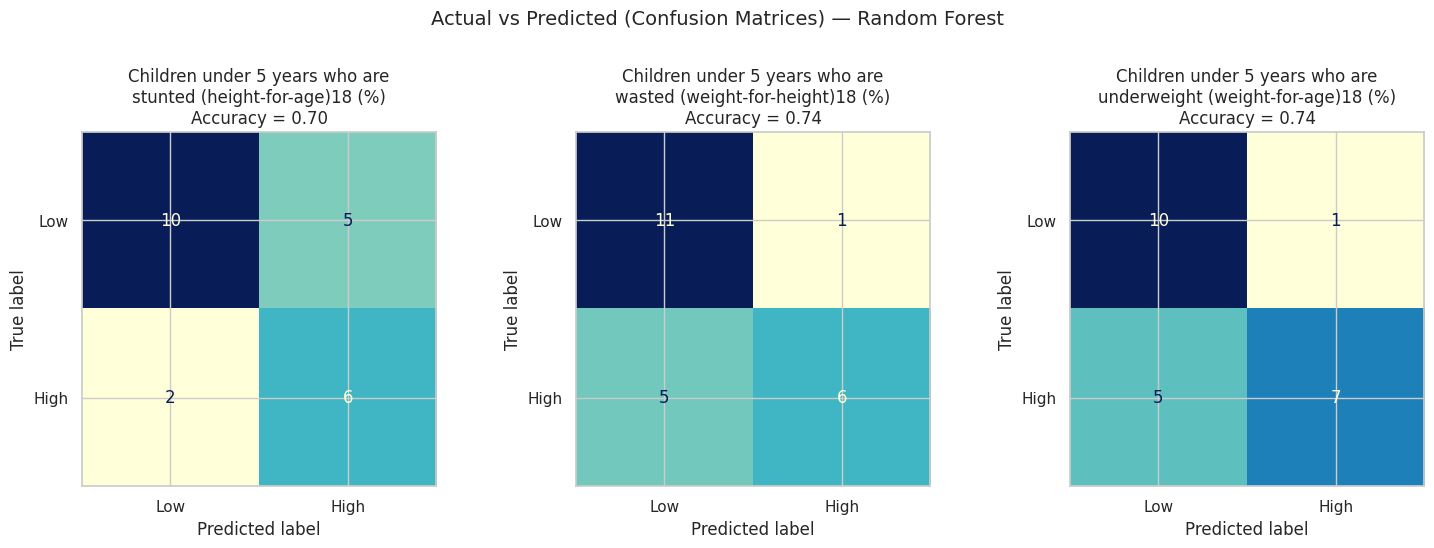


📊 Model: XGBoost


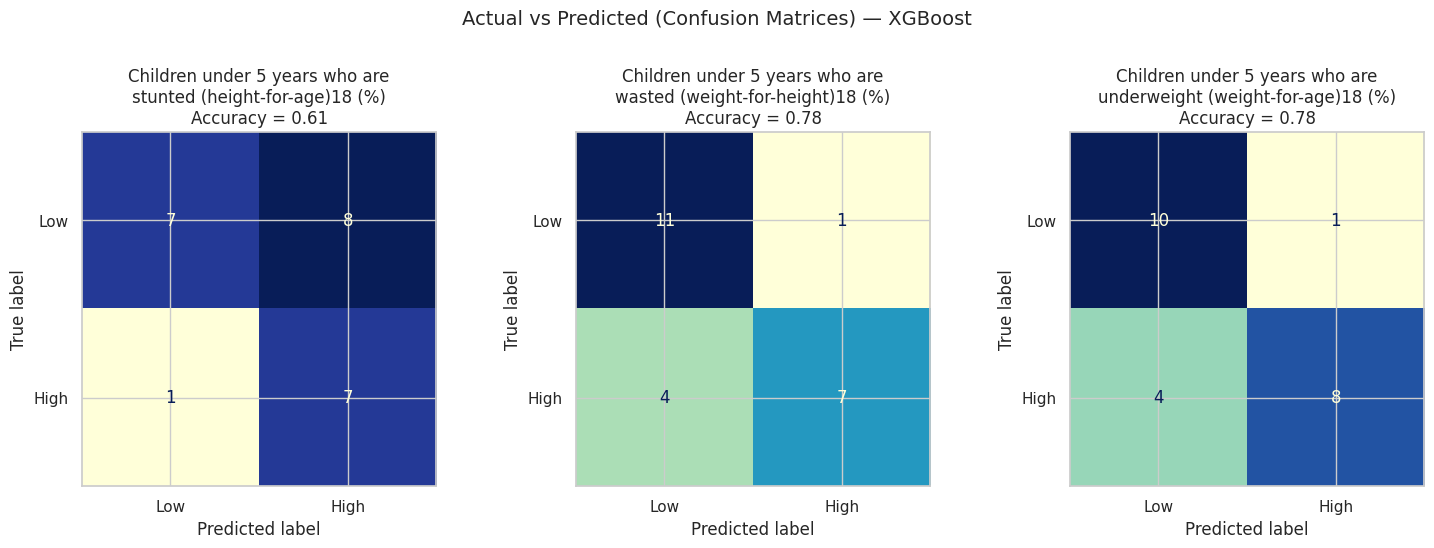

In [66]:
plot_actual_vs_pred_classification(models_class, X_train_c, y_train_c, X_test_c, y_test_c, target_cols)

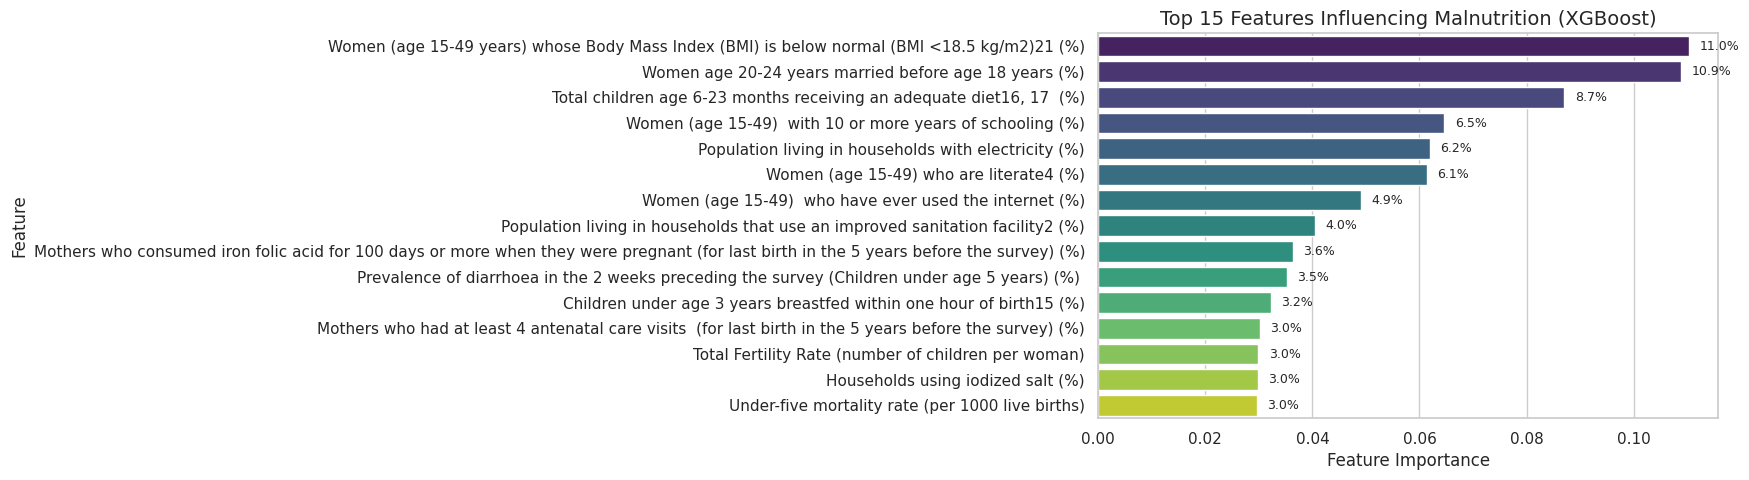

,Feature,Importance
7,Women (age 15-49 years) whose Body Mass Index ...,0.110293
10,Women age 20-24 years married before age 18 ye...,0.108845
2,Total children age 6-23 months receiving an ad...,0.087063
6,Women (age 15-49) with 10 or more years of sc...,0.064623
12,Population living in households with electrici...,0.061910
5,Women (age 15-49) who are literate4 (%),0.061388
11,Women (age 15-49) who have ever used the inte...,0.049101
14,Population living in households that use an im...,0.040448
9,Mothers who consumed iron folic acid for 100 d...,0.036326
3,Prevalence of diarrhoea in the 2 weeks precedi...,0.035201


In [ ]:
feature_names = X_train_c.columns

# ---------------------------------------
# 🎯 Fit the Random Forestt model only
# ---------------------------------------
model = models_class["Random Forest"]   # Use your trained Random Forest classifier
multi_model = MultiOutputRegressor(model)
multi_model.fit(X_train_c, y_train_c)

# ---------------------------------------
# 📊 Compute average feature importance
# ---------------------------------------
importances = np.array([est.feature_importances_ for est in multi_model.estimators_])
avg_importance = importances.mean(axis=0)

# Create DataFrame for top features
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": avg_importance
}).sort_values(by="Importance", ascending=False).head(15)

# ---------------------------------------
# 🎨 Plot Feature Importance
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature",hue="Feature", data=feat_df, palette="viridis",legend=False)
plt.title("Top 15 Features Influencing Malnutrition (XGBoost)", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

# Add percentage labels next to each bar
ax = plt.gca()
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.002, y, f"{width*100:.1f}%", va='center', fontsize=9)

plt.show()

# ---------------------------------------
# 🧾  Display top features in table
# ---------------------------------------
display(feat_df)

In [69]:
numeric_features = [
    'Children under age 6 months exclusively breastfed16 (%)',
    'Children under age 3 years breastfed within one hour of birth15 (%)',
    'Total children age 6-23 months receiving an adequate diet16, 17  (%)',
    'Prevalence of diarrhoea in the 2 weeks preceding the survey (Children under age 5 years) (%) ',
    'Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%)  ',
    'Women (age 15-49) who are literate4 (%)',
    'Women (age 15-49)  with 10 or more years of schooling (%)',
    'Women (age 15-49 years) whose Body Mass Index (BMI) is below normal (BMI <18.5 kg/m2)21 (%)',
    'Mothers who had at least 4 antenatal care visits  (for last birth in the 5 years before the survey) (%)',
    'Mothers who consumed iron folic acid for 100 days or more when they were pregnant (for last birth in the 5 years before the survey) (%)',
    'Women age 20-24 years married before age 18 years (%)',
    'Women (age 15-49)  who have ever used the internet (%)',
    'Population living in households with electricity (%)',
    'Population living in households with an improved drinking-water source1 (%)',
    'Population living in households that use an improved sanitation facility2 (%)',
    'Households using clean fuel for cooking3 (%)',
    'Households using iodized salt (%)',
    'Households with any usual member covered under a health insurance/financing scheme (%)',
    'Total Fertility Rate (number of children per woman)',
    'Neonatal mortality rate (per 1000 live births)',
    'Infant mortality rate (per 1000 live births)',
    'Under-five mortality rate (per 1000 live births)',
    'Current Use of Family Planning Methods (Currently Married Women Age 15-49  years) - Any method6 (%)'
]

In [70]:
# User input values (your previous values)
user_input = {
    'Children under age 6 months exclusively breastfed16 (%)': 55,
    'Children under age 3 years breastfed within one hour of birth15 (%)': 60,
    'Total children age 6-23 months receiving an adequate diet16, 17  (%)': 50,
    'Prevalence of diarrhoea in the 2 weeks preceding the survey (Children under age 5 years) (%) ': 8,
    'Children with fever or symptoms of ARI in the 2 weeks preceding the survey taken to a health facility or health provider (Children under age 5 years) (%)  ': 12,
    'Women (age 15-49) who are literate4 (%)': 72,
    'Women (age 15-49)  with 10 or more years of schooling (%)': 40,
    'Women (age 15-49 years) whose Body Mass Index (BMI) is below normal (BMI <18.5 kg/m2)21 (%)': 15,
    'Mothers who had at least 4 antenatal care visits  (for last birth in the 5 years before the survey) (%)': 80,
    'Mothers who consumed iron folic acid for 100 days or more when they were pregnant (for last birth in the 5 years before the survey) (%)': 60,
    'Women age 20-24 years married before age 18 years (%)': 10,
    'Women (age 15-49)  who have ever used the internet (%)': 50,
    'Population living in households with electricity (%)': 85,
    'Population living in households with an improved drinking-water source1 (%)': 90,
    'Population living in households that use an improved sanitation facility2 (%)': 70,
    'Households using clean fuel for cooking3 (%)': 60,
    'Households using iodized salt (%)': 95,
    'Households with any usual member covered under a health insurance/financing scheme (%)': 40,
    'Total Fertility Rate (number of children per woman)': 2.2,
    'Neonatal mortality rate (per 1000 live births)': 20,
    'Infant mortality rate (per 1000 live births)': 30,
    'Under-five mortality rate (per 1000 live births)': 35,
    'Current Use of Family Planning Methods (Currently Married Women Age 15-49  years) - Any method6 (%)': 60
}

# Create a template with all required features, fill missing with 0
input_template = dict.fromkeys(numeric_features, 0)
input_template.update(user_input)

# Convert to DataFrame
input_df = pd.DataFrame([input_template])

In [71]:
# Predict
model = models_class["Random Forest"]   # Use your trained Random Forest classifier
multi_model = MultiOutputRegressor(model)
multi_model.fit(X_train_c, y_train_c)
predictions = multi_model.predict(input_df)

# Convert predictions to DataFrame
prediction_df = pd.DataFrame(predictions, columns=target_cols)
print(prediction_df)

   Children under 5 years who are stunted (height-for-age)18 (%)  \
0                                                  1               

   Children under 5 years who are wasted (weight-for-height)18 (%)  \
0                                                  0                 

   Children under 5 years who are underweight (weight-for-age)18 (%)  
0                                                  1                  


In [27]:
import pickle

# Assuming `pipeline` is your trained pipeline
with open('malnutrition_model.pkl', 'wb') as f:
    pickle.dump(multi_model, f)